In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.table import Table,hstack
import os
import sys

from PIL import Image
from urllib.request import urlretrieve

In [52]:
homedir = os.getenv('HOME')
cwd = homedir+'/Desktop/summer2023/'
os.chdir(cwd)

In [33]:
cwd2 = homedir+'/Desktop/SummerResearch2023/'

In [3]:
mytablepath=cwd+'data/v2/2022-08-20/'

In [4]:
%run readingtables.py --tabledir {mytablepath}

/Users/ethanjones2/Desktop/summer2023/readingtables.py:146: RuntimeWarning: divide by zero encountered in log10
  g = 22.5 - 2.5*np.log10(dr9['FLUX_G'])
/Users/ethanjones2/Desktop/summer2023/readingtables.py:146: RuntimeWarning: invalid value encountered in log10
  g = 22.5 - 2.5*np.log10(dr9['FLUX_G'])
/Users/ethanjones2/Desktop/summer2023/readingtables.py:147: RuntimeWarning: divide by zero encountered in log10
  r = 22.5 - 2.5*np.log10(dr9['FLUX_R'])
/Users/ethanjones2/Desktop/summer2023/readingtables.py:147: RuntimeWarning: invalid value encountered in log10
  r = 22.5 - 2.5*np.log10(dr9['FLUX_R'])
/Users/ethanjones2/Desktop/summer2023/readingtables.py:148: RuntimeWarning: divide by zero encountered in log10
  z = 22.5 - 2.5*np.log10(dr9['FLUX_Z'])
/Users/ethanjones2/Desktop/summer2023/readingtables.py:148: RuntimeWarning: invalid value encountered in log10
  z = 22.5 - 2.5*np.log10(dr9['FLUX_Z'])
/Users/ethanjones2/Desktop/summer2023/readingtables.py:150: RuntimeWarning: invalid v

In [5]:
filters = ['FUV','NUV','G','R','Z','W1','W2','W3','W4']
fluxes = ['FLUX_AP06_{}'.format(f) for f in filters]
ivars = ['FLUX_IVAR_AP06_{}'.format(f) for f in filters]

wavelengths = np.array([ 0.1516,0.2267,0.48623,0.64606,0.91993,3.40025,4.65201,12.81034,22.37528],'d')

In [6]:
def plotone(igal,subfolder=None):
    
    plt.figure(figsize=(13,6))
    
    plt.subplot(1,2,1)

    # plots fluxes for one galaxy
    
    for i in range(len(wavelengths)):
        ivar=v.ephot[ivars[i]][igal]
    
        if ivar==0:
            erri=1.e3
        else:
            erri=1./np.sqrt(ivar)
        
        fluxi=v.ephot[fluxes[i]][igal]*3.631e-6 # nanomaggies to Jy conversion
        erri=erri*3.631e-6
    
        #plt.scatter(wavelengths[i],v.ephot[fluxes[i]][igal],label=filters[i])
   
        plt.errorbar(wavelengths[i],fluxi,yerr=erri,label=filters[i],fmt='o',markersize=5)
    
    plt.xlabel('Wavelength (micron)',fontsize=14); plt.ylabel('Flux (Jy)',fontsize=14)
    plt.title(v.main['prefix'][igal],fontsize=18)
    plt.legend(fontsize='small')#bbox_to_anchor=(1.2, 0.72), borderaxespad=0)
    ax=plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ###
    plt.subplot(1,2,2)
    ###
    
    # gets legacy image and plots it
    
    ra=v.main['RA'][igal]
    dec=v.main['DEC'][igal]
    galid=v.main['objname'][igal]

    pixscale=1
    imsize='120'
    
    imsize=int(imsize)

    if subfolder is not None:
        if not os.path.exists(subfolder):
            os.mkdir(subfolder)
            rootname = 'legacyimages/'+'/'+str(galid)+'-legacy-'+str(imsize)
    else:
        rootname = 'legacyimages/'+str(galid)+'-legacy-'+str(imsize)
        
    jpeg_name = rootname+'.jpg'
    
    if not(os.path.exists(jpeg_name)):
        print('retrieving ',jpeg_name)
        url='http://legacysurvey.org/viewer/jpeg-cutout?ra='+str(ra)+'&dec='+str(dec)+'&layer=dr8&size='+str(imsize)+'&pixscale='+str(pixscale)
        urlretrieve(url, jpeg_name)
    else:
        print('previously downloaded ',jpeg_name)

    t = Image.open(jpeg_name)
    plt.imshow(t,origin='upper')
    
    titlename=v.main['prefix'][igal]
    plt.title(f'{titlename} Legacy Image',fontsize=18)

In [60]:
#galindices=np.array([4, 7, 30, 137, 557, 727, 827, 1060, 1390, 2579, 4321, 6069, 5286, 5583, 6449, 303, 2767, 3007, 2404, 3079, 3140, 1731],'i')
galindices=np.array(np.arange(1,1001,1))

In [61]:
#galindices

In [62]:
# what to include in output table?
# VFID, prefix, RA, DEC, vr, flux, errors?

In [63]:
main_colnames=['VFID', 'prefix', 'RA', 'DEC', 'vr']
output_table=v.main[main_colnames][galindices]

In [64]:
# photometry table
phot_colnames=fluxes+ivars
phot_table=v.ephot[phot_colnames][galindices]

In [65]:
mag_table=v.magphys['logMstar','logSFR'][galindices]

In [66]:
z0_table=v.z0mgs['logmass','logsfr'][galindices]

In [67]:
final_table=hstack([output_table,phot_table,mag_table,z0_table])

In [68]:
nums = final_table['VFID']
newcolumn=[]
for i in range(len(nums)):
    newnum = int(nums[i].split('VFID')[1])
    newcolumn.append(newnum)

In [69]:
final_table['VFID'] = newcolumn

In [71]:
final_table

VFID,prefix,RA,DEC,vr,FLUX_AP06_FUV,FLUX_AP06_NUV,FLUX_AP06_G,FLUX_AP06_R,FLUX_AP06_Z,FLUX_AP06_W1,FLUX_AP06_W2,FLUX_AP06_W3,FLUX_AP06_W4,FLUX_IVAR_AP06_FUV,FLUX_IVAR_AP06_NUV,FLUX_IVAR_AP06_G,FLUX_IVAR_AP06_R,FLUX_IVAR_AP06_Z,FLUX_IVAR_AP06_W1,FLUX_IVAR_AP06_W2,FLUX_IVAR_AP06_W3,FLUX_IVAR_AP06_W4,logMstar,logSFR,logmass,logsfr
,,,,,,,,,,,,,,,,,,,,,,,,,log(solMass),log(solMass/yr)
int64,bytes36,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
1,VFID0001-NGC4133,182.208,74.9042778,1331.5,0.0,0.0,6538.43,13330.599,20362.889,15457.785,9508.542,43540.25,132720.3,0.0,0.0,0.4967868,0.12255702,0.042135857,0.027017582,0.013813057,9.6718664e-05,3.7952107e-06,9.79049627696711,-0.9706162223147904,9.79,0.13
2,VFID0002-NGC2977,145.944663,74.8595778,3049.4,0.0,776.82153,6290.1787,10889.412,15117.262,11736.12,7325.976,42278.203,59364.473,0.0,0.15184325,0.27529952,0.13612024,0.045901272,0.027664425,0.011155199,6.538513e-05,2.6258197e-06,10.293362554711445,0.0867156639448825,10.35,0.34
3,VFID0003-CGCG352-030,185.5730835,74.8383889,1833.0,0.0,0.0,1472.456,3035.2146,4723.0127,2750.1184,1479.0891,258.73688,236.92433,0.0,0.0,2.2328517,0.417627,0.17292221,0.15213495,0.08245975,0.00094426516,3.704467e-05,9.581949658373318,-2.5415132362017934,9.58,-2.35
4,VFID0004-UGC07189,182.82775049999998,74.8082222,1683.0,0.0,0.0,1339.9755,2566.1816,3198.5505,1862.6222,989.945,2631.895,3091.271,0.0,0.0,1.1856053,0.30258128,0.079070486,0.10534107,0.04100994,0.00022923316,9.067089e-06,9.254306332331286,-2.4046140191908583,9.54,-1.14
5,VFID0005-NGC3752,173.1341835,74.6275401,1920.1,210.4639,322.33075,3742.9502,6841.195,8911.681,6501.1787,3806.7498,14491.306,19376.543,0.013649784,0.023729451,0.3713029,0.11871743,0.026629793,0.034615573,0.011559058,7.032565e-05,2.2361517e-06,9.673020907128896,-0.8285660990569917,9.76,-0.55
6,VFID0006-UGC04202,121.912404,74.5846308,2333.0,0.0,0.0,436.03336,773.5397,926.1702,680.75714,337.89648,707.99805,944.4854,0.0,0.0,0.50576097,0.15267426,0.034080274,0.10524834,0.027378503,8.2842605e-05,3.3551603e-06,8.789792167730676,-2.712198270069774,8.98,-1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,VFID0995-SDSSJ140352.43+553532.4,210.9683063949094,55.592471886453055,1970.6639404296875,13.881525,19.011238,101.044205,147.6848,138.07167,79.70984,38.61945,51.4731,201.02231,7.575039,13.922872,7.5042434,2.5970535,0.46655267,1.2482027,0.3232462,0.001363558,5.519626e-05,7.722140125457416,-2.24649354300903,--,--


In [48]:
#final_table.write('sedsphot3.fits',format='fits',overwrite=True)

In [53]:
final_table.write('sedsphot.csv',format='csv',overwrite=True)

In [50]:
os.chdir(cwd2)

In [51]:
final_table.write('sedsphot.csv',format='csv',overwrite=True)

In [343]:
mag_stellarMasses=final_table['logMstar']
mag_SFRs=final_table['logSFR']

z0_stellarMasses=final_table['logmass']
z0_SFRs=final_table['logsfr']

recessionVels=final_table['vr']

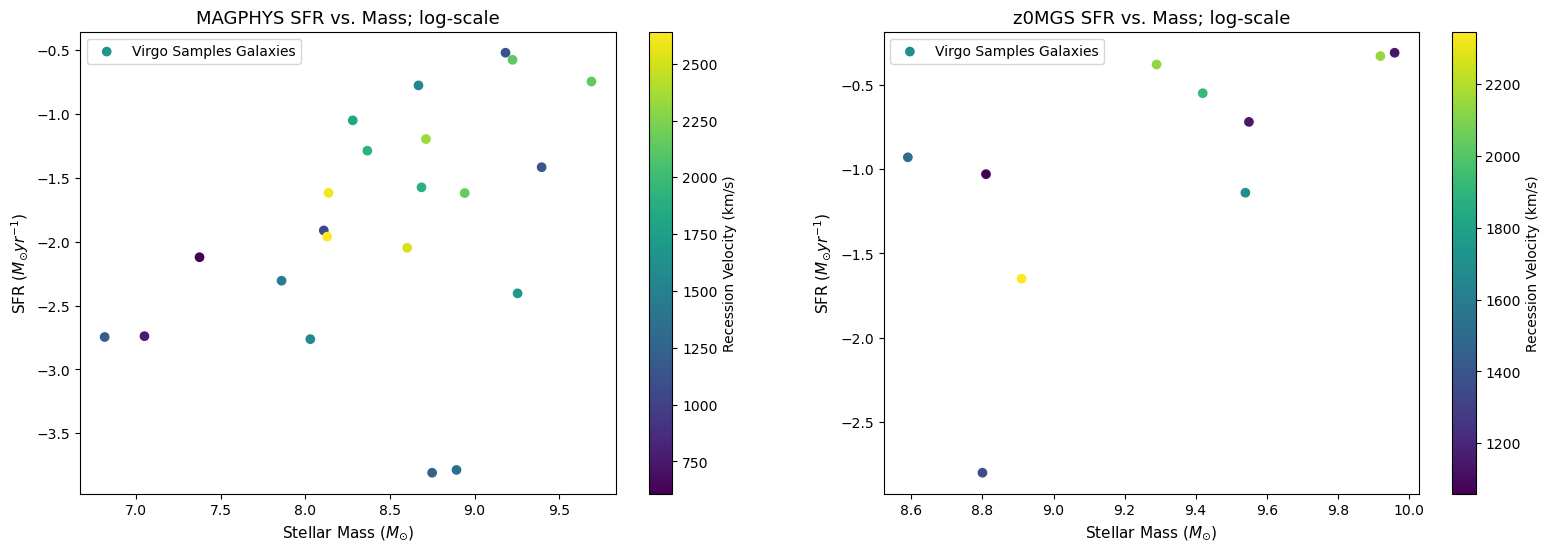

In [344]:
plt.figure(figsize=(19,6))

plt.subplot(1,2,1)
plt.scatter(mag_stellarMasses,mag_SFRs,c=recessionVels,label='Virgo Samples Galaxies')
plt.xlabel('Stellar Mass $(M_{\odot})$',fontsize=11); plt.ylabel('SFR ($M_{\odot}yr^{-1}$)',fontsize=11)
plt.title('MAGPHYS SFR vs. Mass; log-scale',fontsize=13)
colorbar=plt.colorbar()
colorbar.set_label('Recession Velocity (km/s)')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(z0_stellarMasses,z0_SFRs,c=recessionVels,label='Virgo Samples Galaxies')
plt.xlabel('Stellar Mass $(M_{\odot})$',fontsize=11); plt.ylabel('SFR ($M_{\odot}yr^{-1}$)',fontsize=11)
plt.title('z0MGS SFR vs. Mass; log-scale',fontsize=13)
colorbar=plt.colorbar()
colorbar.set_label('Recession Velocity (km/s)')
plt.legend()

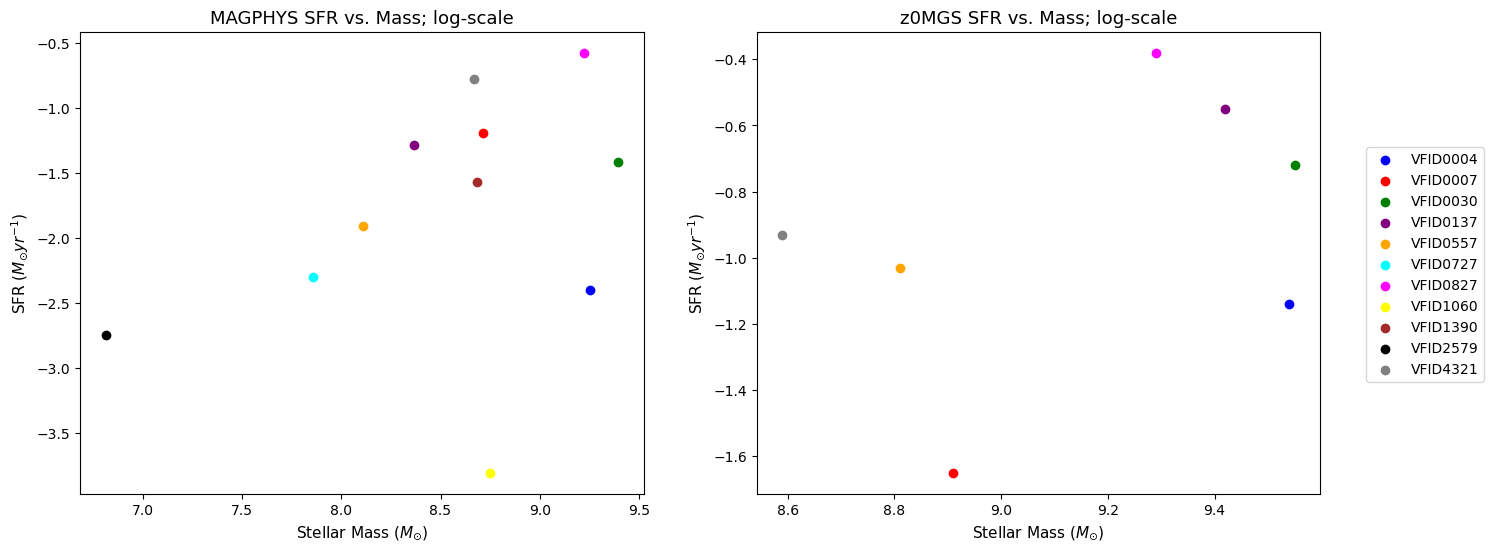

In [74]:
cols=['blue','red','green','purple','orange','cyan','magenta','yellow','brown','black','gray']
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for i in range(len(final_table)):
    plt.scatter(final_table[i]['logMstar'],final_table[i]['logSFR'],c=cols[i],label=final_table[i]['VFID'])
plt.xlabel('Stellar Mass $(M_{\odot})$',fontsize=11); plt.ylabel('SFR ($M_{\odot}yr^{-1}$)',fontsize=11)
plt.title('MAGPHYS SFR vs. Mass; log-scale',fontsize=13)

plt.subplot(1,2,2)
for i in range(len(final_table)):
    plt.scatter(final_table[i]['logmass'],final_table[i]['logsfr'],c=cols[i],label=final_table[i]['VFID'])
plt.xlabel('Stellar Mass $(M_{\odot})$',fontsize=11); plt.ylabel('SFR ($M_{\odot}yr^{-1}$)',fontsize=11)
plt.title('z0MGS SFR vs. Mass; log-scale',fontsize=13)

plt.legend(bbox_to_anchor=(1.29, 0.75), borderaxespad=0)


In [193]:
final_table

VFID,RA,DEC,vr,FLUX_AP06_FUV,FLUX_AP06_NUV,FLUX_AP06_G,FLUX_AP06_R,FLUX_AP06_Z,FLUX_AP06_W1,FLUX_AP06_W2,FLUX_AP06_W3,FLUX_AP06_W4,FLUX_IVAR_AP06_FUV,FLUX_IVAR_AP06_NUV,FLUX_IVAR_AP06_G,FLUX_IVAR_AP06_R,FLUX_IVAR_AP06_Z,FLUX_IVAR_AP06_W1,FLUX_IVAR_AP06_W2,FLUX_IVAR_AP06_W3,FLUX_IVAR_AP06_W4,logMstar,logSFR,logmass,logsfr
,,,,,,,,,,,,,,,,,,,,,,,,log(solMass),log(solMass/yr)
int64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
4,182.82775049999998,74.8082222,1683.0,0.0,0.0,1339.9755,2566.1816,3198.5505,1862.6222,989.945,2631.895,3091.271,0.0,0.0,1.1856053,0.30258128,0.079070486,0.10534107,0.04100994,0.00022923316,9.067089e-06,9.254306332331286,-2.4046140191908583,9.54,-1.14
7,118.2363,74.576533,2346.0,59.82642,100.33042,598.78436,882.03424,914.67444,561.1521,291.01056,911.88336,1844.9708,0.21526209,0.3537793,0.95184726,0.22888139,0.14147319,0.20178816,0.058447827,0.00014652764,5.8879596e-06,8.712733859069951,-1.1963380767637757,8.91,-1.65
30,158.5963845,73.7650129,1148.8,139.28181,181.67604,2917.8572,5870.292,7953.9497,6853.166,4133.4287,16818.896,22500.836,0.019447688,0.03992147,0.87559503,0.4187658,0.08302201,0.05542439,0.026153103,0.00018879957,7.530009e-06,9.396548037987133,-1.4168012260313771,9.55,-0.72
137,157.60279200000002,70.0515889,1920.1,95.84248,133.71497,618.5032,907.1038,671.4357,424.81488,244.4251,781.1526,1138.1084,0.5713591,2.205407,5.4937634,1.515365,0.5088841,0.5134294,0.1723704,0.0009812106,3.1175485e-05,8.366236123718293,-1.2875186621980812,9.42,-0.55
557,168.33596400000002,59.9079749,1059.4,145.23416,192.89594,1273.6481,2042.1467,1732.6859,722.4523,386.17392,717.03754,1499.1147,0.018392712,0.035666373,1.1627412,0.45355424,0.103639714,0.21608697,0.0624039,0.00020048894,8.128932e-06,8.108565023732835,-1.9118639112994487,8.81,-1.03
727,168.887676,58.4784112,1451.9,23.15852,51.06671,378.02786,559.49084,365.3947,288.65244,154.50342,153.42169,-557.8418,1.0941713,1.382221,1.1057034,0.36448264,0.12020839,0.22219872,0.05602648,0.00021865554,8.779275e-06,7.858897957232004,-2.3057458879747217,--,--
827,200.2180545,57.6448147,2133.6,528.8115,661.17255,2895.5334,4094.6985,4229.092,3041.6982,1839.0522,7783.6587,18698.906,0.0064876117,0.02991884,0.83183944,0.30831325,0.08231401,0.11543775,0.049552817,0.00027679754,1.0892923e-05,9.224533062606085,-0.575935474582512,9.29,-0.38
1060,175.61340900000002,54.8189902,1246.3,2.6632447,16.08678,833.795,1608.7867,2107.3481,1145.5312,587.247,153.07756,-270.62054,0.4959442,4.524453,1.954956,0.38477683,0.19575268,0.20373689,0.06741864,0.00026283006,1.0806091e-05,8.748962861256162,-3.8091082830778302,--,--


In [97]:
ID = 'VFID0004'

# Retrieve the row(s) where the column matches the desired value
nrow = [row for row in final_table if row['VFID'] == ID][0]

In [98]:
nrow

VFID,prefix,RA,DEC,vr,FLUX_AP06_FUV,FLUX_AP06_NUV,FLUX_AP06_G,FLUX_AP06_R,FLUX_AP06_Z,FLUX_AP06_W1,FLUX_AP06_W2,FLUX_AP06_W3,FLUX_AP06_W4,FLUX_IVAR_AP06_FUV,FLUX_IVAR_AP06_NUV,FLUX_IVAR_AP06_G,FLUX_IVAR_AP06_R,FLUX_IVAR_AP06_Z,FLUX_IVAR_AP06_W1,FLUX_IVAR_AP06_W2,FLUX_IVAR_AP06_W3,FLUX_IVAR_AP06_W4,logMstar,logSFR,logmass,logsfr
,,,,,,,,,,,,,,,,,,,,,,,,,log(solMass),log(solMass/yr)
bytes8,bytes36,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
VFID0004,VFID0004-UGC07189,182.82775049999998,74.8082222,1683.0,0.0,0.0,1339.9755,2566.1816,3198.5505,1862.6222,989.945,2631.895,3091.271,0.0,0.0,1.1856053,0.30258128,0.079070486,0.10534107,0.04100994,0.00022923316,9.067089e-06,9.254306332331286,-2.4046140191908583,9.54,-1.14


In [ ]:
cat 

In [168]:
seds=Table.read('seds_phot.csv')

In [194]:
seds1=np.loadtxt('sedsphot.csv',delimiter=',',skiprows=2,usecols=np.arange(0,22))

In [237]:
ID='7'
ID=int(ID)

In [238]:
#nrow = [row for row in seds1 if seds1[0][0] == ID]

In [245]:
#flux=[]
#fluxerr=[]

for i in range(len(seds1)):
    
    if ID == seds1[i][0]:
        
        flux = seds1[i,4:13]*(3.631e-6)*(1e6)
        fluxerr = seds1[i,13:]*(3.631e-6)*(1e6)
        
        #print(f'{ID} = true')
        
    #else:
        
        #print('false')

In [247]:
fluxerr

array([7.81616631e-01, 1.28457259e+00, 3.45615738e+00, 8.31068323e-01,
       5.13689149e-01, 7.32692799e-01, 2.12224059e-01, 5.32041874e-04,
       2.13791812e-05])

In [249]:
seds1[0][3]

2346.0

In [250]:
flux

array([ 217.2297304 ,  364.29976028, 2174.1860213 , 3202.66632806,
       3321.18288611, 2037.54327368, 1056.65934003, 3311.04848676,
       6699.08906628])

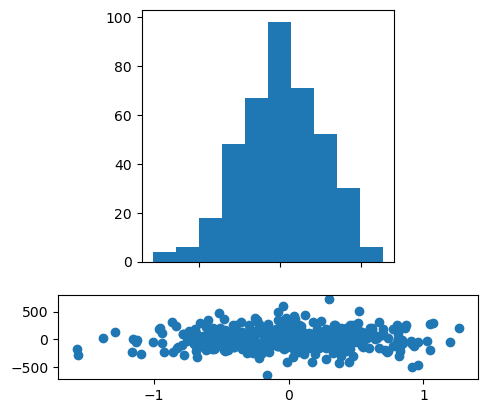

In [323]:
#plt.figure()
fig5,axs = plt.subplots(2, 1, sharex="col", sharey="row",
                         gridspec_kw=dict(height_ratios=[6, 2],
                                          width_ratios=[6]))
#axs[0, 1].set_visible(False)
#axs[1, 1].set_visible(False)


axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1/5)


np.random.seed(19680801)  # Fixing random state for reproducibility
x, y = np.random.randn(2, 400) * [[.5], [180]]
axs[1].scatter(x, y)
axs[0].hist(x)
#axs[1, 1].hist(y, orientation="horizontal")

plt.show()